<a href="https://colab.research.google.com/github/nevermind78/EXAM_LAB_GL42023/blob/master/Exam_E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exam Time Series Forecasting Using Multilayer Perceptron (MLP)



# Execute this cell to initialize the Exam Lab

In [ ]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone datasets
    if not Path('datasets/others').is_dir():
        !ghclone https://github.com/nevermind78/EXAM_LAB_GL42023/tree/master/datasets/others
    else:
        print('datasets/others!')

    # clone library subdirectory
    if not Path('notebook').is_dir():
        !ghclone https://github.com/nevermind78/EXAM_LAB_GL42023/tree/master/notebook
    else:
        print('notebook already cloned!')

    # clone images
    if not Path('picture').is_dir():
        !ghclone https://github.com/nevermind78/EXAM_LAB_GL42023/tree/master/picture
    else:
        print('picture already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./datasets/others')
sys.path.append('./notebook') 
sys.path.append('./picture') 

## Notebook Description
The deep learning framework used here is PyTorch. An exercise section is attached for you to practice and hone your skills. Do make good use of it.

Objectives:

1. Prepare dataset to be feed into MLP model
2. Build and apply MLP model to perform forecasting
3. Compare and contrast performance of MLP model

## Notebook Outline
Below is the outline for this Lab exam:
1. [Notebook Configurations](#configuration)
2. [Dataset](#dataset)
3. [Basic Analytics](#analytics)
4. [Model Development](#model-dev)
5. [Evaluation](#evaluation)


## <a name="configuration">Notebook Configurations</a>
Following are the modules that will be used for this exam lab. This notebook will heavily use `torch` as they provide great APIs when for building deep learning models. You can find out more about them [here](https://pytorch.org/).

In [ ]:
# Importing libraries
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from sklearn.metrics import mean_squared_error

# seed configuration
np.random.seed(38)
torch.manual_seed(38)

## <a name="dataset">Dataset</a>
We would be using the a time series data containing sales data.  We will split the data into training and test dataset.

> `Sales_Data.csv` located in the path `datasets\others\`

In [ ]:
# specify the path of 
path="______________________________"
# import dataset put the full path below 
df = pd.read_csv(path)

## <a name="analytics">Basic Analytics</a>
Let's do some basic analytics and see what nugget can we find out of the training dataset! Let first find out the number of rows and columns of the training dataset.

**Note: Since we are not supposed to know any information about the test dataset, we will not perform any analytics on it.**

In [ ]:
# inspect first 15 rows of data
df.head()

,date,sales
0,2013-01-01,1742
1,2013-01-02,1808
2,2013-01-03,1887
3,2013-01-04,1983
4,2013-01-05,2087


We can see that there are 8 columns. Let's also inspect the data type for each column.

In [ ]:
# compute dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1826 non-null   object
 1   sales   1826 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 28.7+ KB


Now, we will compute the descriptive statistics.

In [ ]:
# compute descriptive statistics
df.describe()

,sales
count,1826.000000
mean,3351.658269
std,824.945758
min,1496.000000
25%,2724.500000
50%,3310.500000
75%,3929.000000
max,5839.000000


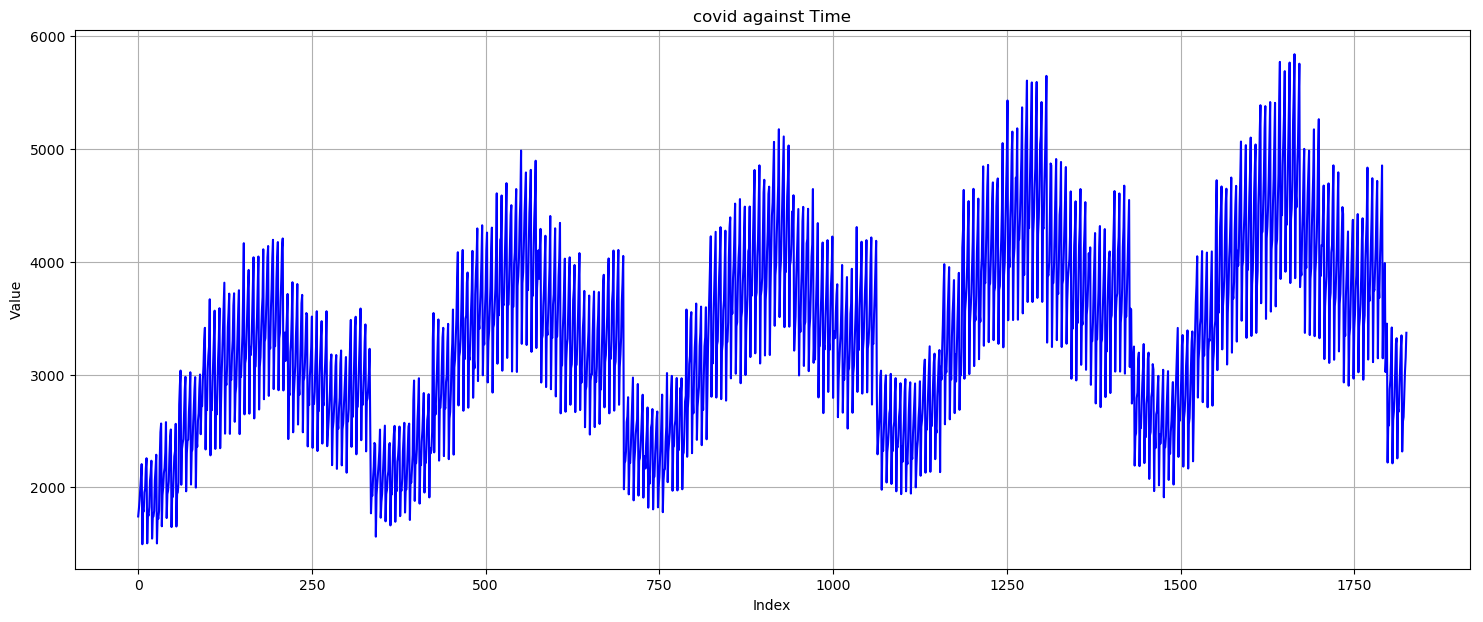

In [ ]:
# plot time plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("covid against Time")
ax.grid(True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df['sales'],
    color='blue', label='Data');

Now that we get to feel the ebb and flow of the data. Let's split the dataset into training and test set.

In [ ]:
# split dataset , specify the train_size
df_train, df_test = train_test_split(df, train_size=_, shuffle=False)

# display training dataset length
print(f"The length of training dataset is: {len(df_train)}")

# display test dataset length
print(f"The length of test dataset is: {len(df_test)}")

The length of training dataset is: 1734
The length of test dataset is: 92


Let's see what are the portion of dataset which is splitted as training dataset and test dataset.

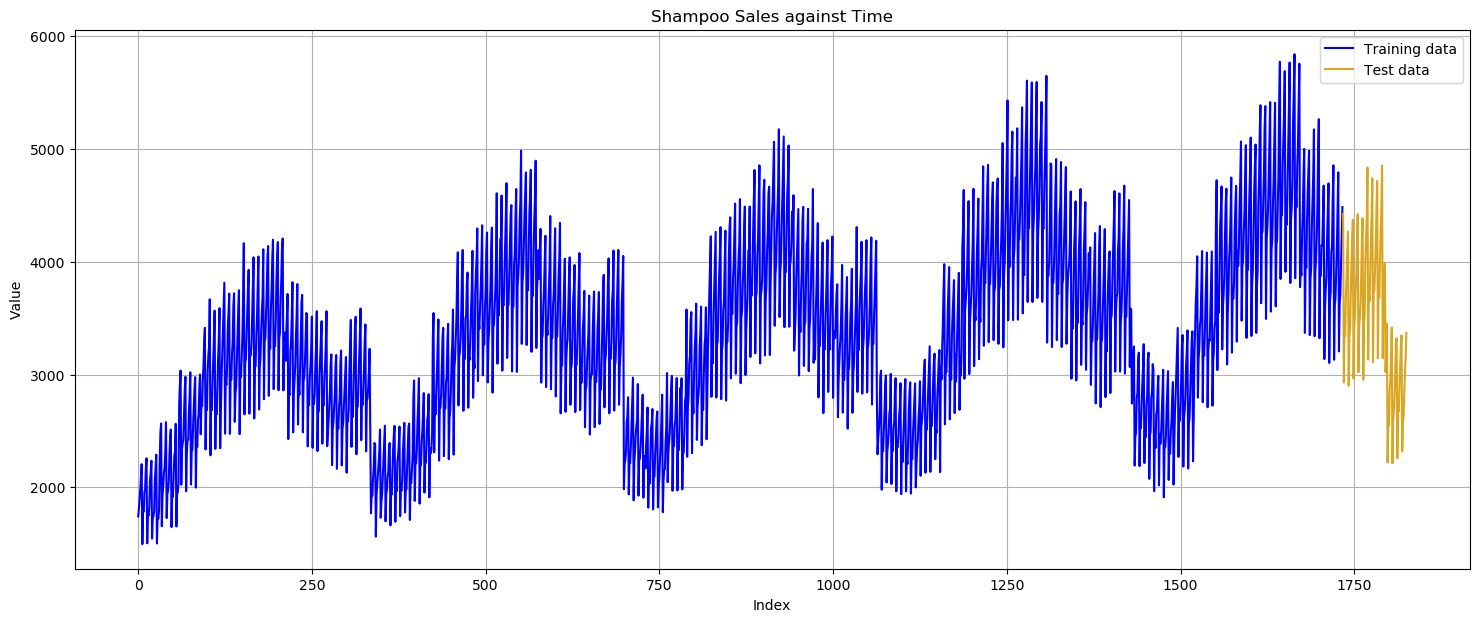

In [ ]:
# plot time plot for training and test dataset 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Shampoo Sales against Time")
ax.grid(b=True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df_train['sales'],
    color='blue', label='Training data');
ax.plot(
    df_test['sales'],
    color='goldenrod', label='Test data')
ax.legend();

Feature scalinng also help in shortening model training time. Let's do that too.

In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train['sales'].values.reshape(-1,1))
test_scaled = scaler.transform(df_test['sales'].values.reshape(-1,1))

## <a name="model-dev">Model Development</a>
The `torch` library provides a number of API to easily construct a MLP model for the tasks at hand. But first, we will need to prepare the dataset into a format ingestible by the model first. We will first transform the time series data into feature of label, where the feature would be a sequence of *n* length of data and label would be lead-1 of the last data in the feature.

In [ ]:
# write a helper function which slices through the features using the sequence_length parameter and index the labe at the time step
# function should return features in sequence and labels
def sequencing_data(data, sequence_length):
    """
    Helper function to sample sub-sequence of training data.
    Input data must be in np.ndarray.
    """
    x, y = [], []

    for i in range(data.shape[0] - sequence_length):

        # copy the sequences of data starting at this index
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return x, y

# calling the helper function and store them in variables
# find appropriate sequence lentgh and complete the code
X_sequence_train, y_sequence_train = sequencing_data(train_scaled, _)
X_sequence_test, y_sequence_test = sequencing_data(test_scaled, _)

# sanity check 
print("Total samples for X train: " + str(len(X_sequence_train)))
print("Total samples for y train: " + str(len(y_sequence_train)))
print("Total samples for X test: " + str(len(X_sequence_test)))
print("Total samples for y test: " + str(len(y_sequence_test)))

Total samples for X train: 1720
Total samples for y train: 1720
Total samples for X test: 78
Total samples for y test: 78


Let's write a custom `Dataset` class to transfrom the data into tuples of `torch.Tensor`. This is necessary if we want to load the data in batches using `DataLoader`.

In [ ]:
class ShampooDataset(Dataset):
    """
    Convert input data into torch FloatTensor. 
    Inherit Dataset class. Return length of instance when len method is called and return specific sample
    of data when indexed.
    """ 
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

We will write the codes to convert data into `Dataset` object and then into `DataLoader` object. We will be using a batch size of 4 for this `DataLoader` object.

In [ ]:
# declare batch size, choose a batch size
batch_size = _

# convert into Dataset using customized class
train_Dataset = ShampooDataset(X_sequence_train, y_sequence_train)
test_Dataset = ShampooDataset(X_sequence_test, y_sequence_test)

# convert into DataLoader
train_loader = DataLoader(train_Dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_Dataset, batch_size=batch_size, shuffle=False)

# declare a dict object
dataloaders = {'train': train_loader, 'test': test_loader} 

It's about time to declare our MLP model architecture. The following code demonstrates how to build a simple MLP model.

In [ ]:
class MLP(nn.Module):
    """MLP model with configurable input size and output size."""
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.input = nn.Linear(input_size, 64)
        self.linear1 = nn.Linear(64, 16)
        self.output = nn.Linear(16, output_size)
    
    def forward(self, x):
        x = x.view(-1, 1, 14)
        out = F.relu(self.input(x))
        out = F.relu(self.linear1(out))
        out = self.output(out)
        return out

Before we can start our training, we also need to configure some hyperparameters. Let's do that.

In [ ]:
# reproducibility
torch.manual_seed(38) # don't change the seed number 38

# setting hyperparameter choose the parameter here
input_size = _
output_size = _
epochs = _
learning_rate = _

# instantiate the model
model = MLP(input_size, output_size)

# continue setting hyperparameter
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

We can perform our model training now. In `torch`, we need to manually write codes to implement model training.

In [ ]:
# implement model training and validation loop
loss_score = {'train': [], 'test': []}
for epoch in range(epochs):
#     print(f'Epoch {epoch+1}/{epochs}')
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        loss_cumsum = 0.0
        total_iterations = 0.0

        for i, (X, y) in enumerate(dataloaders[phase]):
            with torch.set_grad_enabled(phase == 'train'):
                out = model(X)
                loss = criterion(out.squeeze(), y.squeeze())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            loss_cumsum += loss.item() * out.size(0)
            total_iterations += out.size(0)

        epoch_loss = loss_cumsum / total_iterations
#         print(f'{phase.upper()} Loss: {epoch_loss}')
        loss_score[phase].append(epoch_loss)

We can plot the loss score to check how is the model performing when trained by epochs.

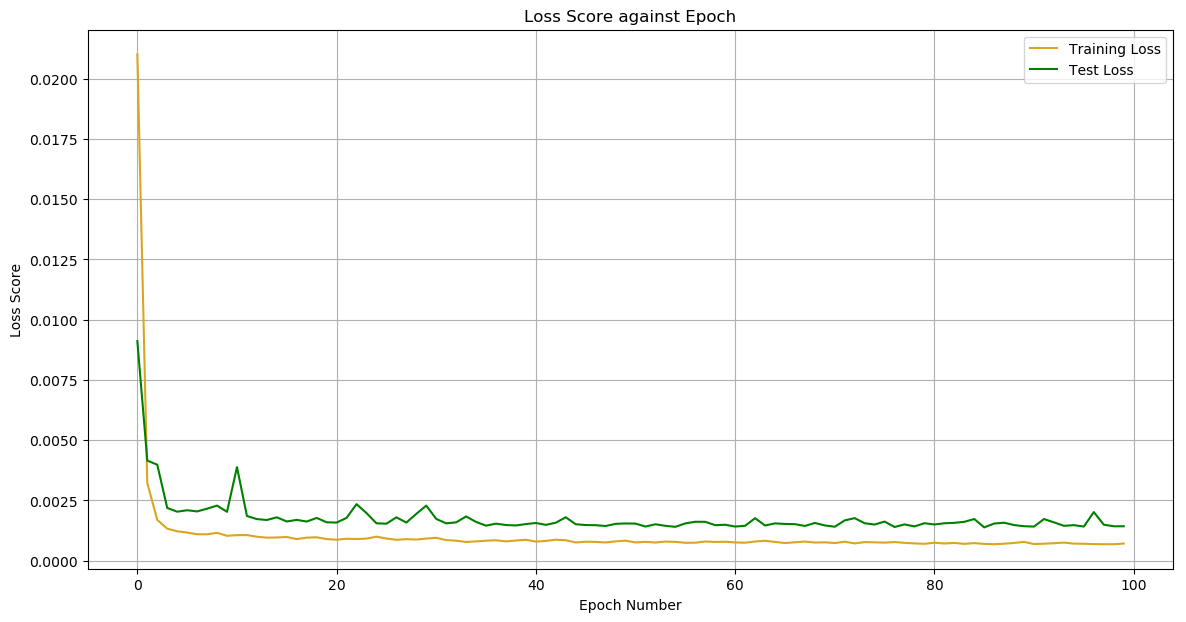

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
ax.set_title("Loss Score against Epoch")
ax.grid(True)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss Score")

ax.plot(loss_score['train'], color='goldenrod', label='Training Loss')
ax.plot(loss_score['test'], color='green', label='Test Loss')
ax.legend();

## <a name="evaluation">Evaluation</a>
There are a few metrics that can be used to evaluate the performance of a regression model, which include:
* mean squared error (MSE)
* root mean squared error (RMSE)
* mean absolute error (MAE)

We will examine the performance of the model on test set using RMSE. 

In [ ]:
model.eval()

predictions = []
count = 0

# model predictions
with torch.no_grad():
    for i, (X, y) in enumerate(DataLoader(test_Dataset, 1)):
        count += 1
        output = model(X)
        predictions.append(output.item())
        
# convert list into np array and inverse transform it into proper values before feature scaling
predictions = np.array(predictions)
predictions = scaler.inverse_transform(predictions.reshape(1,-1))

# remove beginning 3 rows of data since at least 3 data are needed to make a prediction
df_test = df_test.iloc[14:]
df_test['preds'] = predictions.squeeze()

# compute MSE
RMSE = mean_squared_error(df_test.preds, df_test.sales, squared=False)
print(f"The RMSE for the model is {RMSE}")

The RMSE for the model is 164.2204854221156


We can also print and visualize predictions made by the model for inspection purpose.

1748    4370.980836
1749    2901.234539
1750    3366.100664
1751    3393.886368
1752    3695.381613
           ...     
1821    2607.672926
1822    2790.763989
1823    3006.773620
1824    3175.387899
1825    3305.127950
Name: preds, Length: 78, dtype: float64


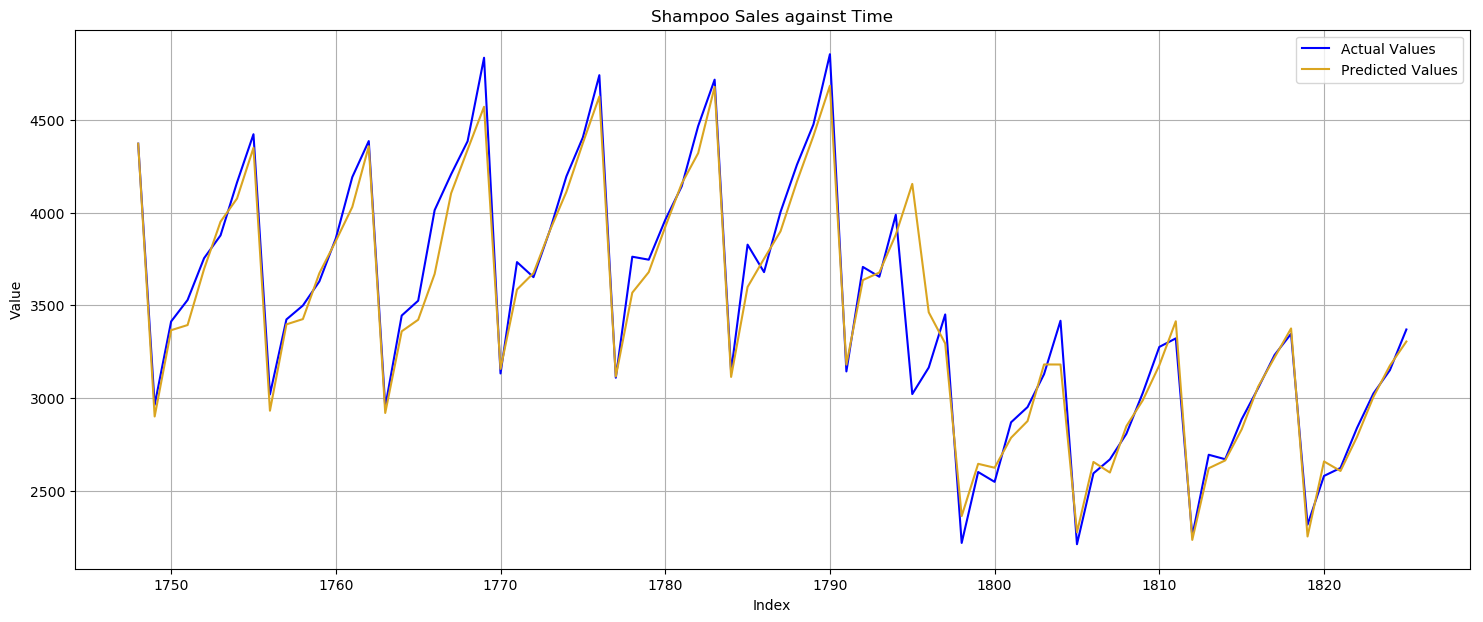

In [ ]:
print(df_test['preds'])

# plot time plot for predictions and ground truth 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Shampoo Sales against Time")
ax.grid(b=True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df_test['sales'],
    color='blue', label='Actual Values');
ax.plot(
    df_test['preds'],
    color='goldenrod', label='Predicted Values')
ax.legend();

# Fine Tuning
* Try to use 3 Hidden Layer in The MLP architecture 
* Is there any boost of  performence ?
* Write Down The better parameter You find and the RMSE error that you get:
    * train/test split percentage ?
    * lag : or sequence of historical day  for prediction
    * Learning rate
    * Number of hidden layer 
* Explain the importance of all these parameters ( lag, batch sise, hidden layer , learning rate ...)

## Answer This [Form](https://forms.gle/nZbFAsoGKGKaCqwQA)